# Setup

Imports

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from tqdm import tqdm

In [2]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [4]:
device = torch.device('cpu')

In [31]:
env = 'CartPole-v1'

In [32]:
env = gym.make(env)

In [39]:
def step_env(action, step=None):
    observation, reward, done, info = env.step(action)
    
    if done and step != 499: reward = -1
    
    elif reward == 1: reward = 0.00
    return observation, reward, done, info

In [40]:
def run_env(learner=None, render=False, episodes=1, dilate=0):
    if learner is None: learner = lambda x: env.action_space.sample()
        
    rewards = 0
    for _ in range(episodes):
        observation = env.reset()
        done = False
        step = 0
        while not done:
            if render: 
                env.render()
                sleep(dilate)
                
            action = learner(observation)
            observation, reward, done, info = step_env(action, step)
            rewards += reward
            step += 1
    if render: env.close()
    return rewards

In [41]:
def get_learner(weights=None):
    if weights is None: weights = np.random.randn(a, n)
    return lambda observation: (weights @ observation).argmax()

In [42]:
n = env.observation_space.shape[0]
a = env.action_space.n

In [43]:
def evolve(steps, episodes=1):
    weight = np.zeros((a, n))
    max_reward = -np.inf

    for _ in tqdm(range(steps)):
        w = np.random.randn(a, n)
        reward = run_env(get_learner(w), episodes=episodes)
        if reward > max_reward:
            max_reward = reward
            weight = w
            
    return max_reward, weight

In [45]:
max_reward, weight = evolve(100, 5)
run_env(get_learner(weight), render=True, dilate=0.01)

100%|██████████| 100/100 [00:00<00:00, 602.68it/s]


0.0

# Train Model

In [46]:
class CartLearner(nn.Module):
    def __init__(self, n, a, h):
        super().__init__()
        self.rnn = nn.LSTMCell(n + a, h)
        self.fc = nn.Linear(h, a)
        
        self.reset()
        
    def forward(self, s, a=None):
        if a is None: a = torch.zeros(self.fc.out_features, device=device)
            
        x = torch.cat([s, a]).unsqueeze(dim=0)
        
        self.h = self.rnn(x, self.h)
        return self.fc(self.h[0]).squeeze()
    
    def reset(self):
        self.h = None

In [47]:
learner = CartLearner(n, a, 10).to(device)

In [48]:
optimizer = optim.Adam(learner.parameters())

In [52]:
def train(learner, optimizer, steps, dry_run=False, dilate=0):
    torch.set_grad_enabled(not dry_run)
    
    done = False

    observation = None
    action = None
    learner.reset()
    if not dry_run: optimizer.zero_grad()
    episodic_rewards = [0]
    
    pbar = range(steps)
    if not dry_run: pbar = tqdm(pbar)
        
    for i in pbar:
        if done:
            observation = None
            action = None
            learner.reset()
            episodic_rewards.append(0)
            if not dry_run: pbar.set_description(f'{episodic_rewards[-2]:.2f}')

        if observation is None: observation = env.reset()
        if action is None: action = torch.zeros(learner.fc.out_features, device=device)

        if dry_run: 
            env.render()
            sleep(dilate)
        else:
            optimizer.zero_grad()
        action = learner(torch.tensor(observation, dtype=torch.float32, device=device), action)
        observation, reward, done, _ = step_env(action.max(0)[1].item())
        if reward != 0 and not dry_run:
            grad = torch.tensor(-reward, dtype=torch.float32, device=device)
            grad = grad.expand(learner.h[0].shape)
            learner.h[0].backward(grad, retain_graph=True)
            optimizer.step()

        episodic_rewards[-1] += reward
    
    if dry_run: env.close()
        
    return episodic_rewards

In [54]:
episodic_rewards = train(learner, optimizer, 10000)

-1.00: 100%|██████████| 10000/10000 [00:05<00:00, 1955.04it/s]


In [55]:
episodic_rewards.pop()

0.0

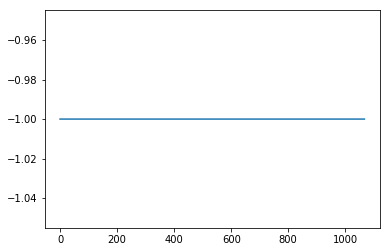

In [56]:
plt.plot(episodic_rewards)

In [57]:
train(learner, optimizer, 100, dry_run=True, dilate=0.01)

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]